In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
loans = pd.read_csv('data/lending-club-data.csv')
train_idx = pd.read_json('data/module-8-assignment-1-train-idx.json')[0]
validation_idx = pd.read_json('data/module-8-assignment-1-validation-idx.json')[0]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop(columns=['bad_loans'])
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[[target] + features].dropna()
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
def one_hot_encoding(df, target):
    categorical_features = []
    for feature_name, feature_type in zip(df.columns, df.dtypes):
        if feature_type is np.dtype('O'):
            categorical_features.append(feature_name)
            
    for feature_name in categorical_features:
        df2 = pd.get_dummies(df[feature_name],prefix=feature_name)
        df = df.join(df2).drop([feature_name], axis=1)

    t = df[target]
    return (df.drop([target], axis=1), t)


train_data, train_target = one_hot_encoding(train_data, target)
validation_data, validation_target = one_hot_encoding(validation_data, target)

In [6]:
from sklearn import ensemble

gbc_5 = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=5)
gbc_5.fit(train_data, train_target)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [4]:
validation_safe_loans = validation_data[validation_target == 1]
validation_risky_loans = validation_data[validation_target == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
26,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
24,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
41,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [7]:
gbc_5.predict(sample_validation_data)

array([ 1,  1, -1,  1], dtype=int64)

In [8]:
gbc_5.predict_proba(sample_validation_data)

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

In [9]:
gbc_5.classes_

array([-1,  1], dtype=int64)

In [21]:
print('Score(accuarcy): ',gbc_5.score(validation_data, validation_target))
false_positive = (np.logical_and( gbc_5.predict(validation_data)==1, validation_target==-1)).sum()
false_negative = (np.logical_and( gbc_5.predict(validation_data)==-1, validation_target==1)).sum()
print('false positves: ',false_positive)

# False negatives: Assume a cost of $10,000 per false negative.
# False positives: Assume a cost of $20,000 per false positive.
print('Cost: ', 10000*false_negative+20000*false_positive)

Score(accuarcy):  0.6613528651443343
false positves:  1653
Cost:  47970000


In [85]:
origin = loans.iloc[validation_idx]['grade']
# gbc_5.predict_proba(validation_data)[:1]
origin = pd.DataFrame({'grade':origin, 'prob':gbc_5.predict_proba(validation_data)[:,1]})
origin.sort_values(by=['prob'], ascending=False).iloc[:5]

# origin.sort_values(by=['prob'], ascending=False).loc[:5] =>
# 'the label [1] is not in the [index]'

,grade,prob
8021,A,0.673059
16736,A,0.661468
67183,A,0.661468
27214,A,0.661468
73426,A,0.661468


In [87]:
gbc_10 = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=10)
gbc_10.fit(train_data, train_target)
gbc_50 = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=50)
gbc_50.fit(train_data, train_target)
gbc_100 = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=100)
gbc_100.fit(train_data, train_target)
gbc_200 = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=200)
gbc_200.fit(train_data, train_target)
gbc_500 = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=500)
gbc_500.fit(train_data, train_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [88]:
print(gbc_10.score(validation_data, validation_target))
print(gbc_50.score(validation_data, validation_target))
print(gbc_100.score(validation_data, validation_target))
print(gbc_200.score(validation_data, validation_target))
print(gbc_500.score(validation_data, validation_target))

0.6663076260232659
0.6816027574321413
0.6890348987505386
0.6896811719086601
0.6875269280482551


In [89]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

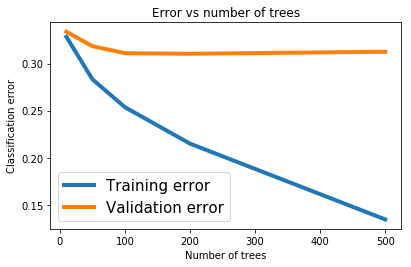

In [93]:
error_10 = 1-gbc_10.score(validation_data, validation_target)
error_50 = 1-gbc_50.score(validation_data, validation_target)
error_100 = 1-gbc_100.score(validation_data, validation_target)
error_200 = 1-gbc_200.score(validation_data, validation_target)
error_500 = 1-gbc_500.score(validation_data, validation_target)
validation_errors = [error_10, error_50, error_100, error_200, error_500]

training_errors = [1-gbc_10.score(train_data, train_target),
                 1-gbc_50.score(train_data, train_target),
                 1-gbc_100.score(train_data, train_target),
                 1-gbc_200.score(train_data, train_target),
                 1-gbc_500.score(train_data, train_target)]

plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

## Notes:

In [63]:
# Build df from Series and np.array
author = ['Jitender', 'Purnima', 'Arpit', 'Jyoti'] 
article = [210, 211, 114, 178] 
  
auth_series = pd.Series(author) 
article_series = np.array(article) 
  
frame = { 'Author': auth_series, 'Article': article_series } 
  
result = pd.DataFrame(frame) 
  
print(result) 


# indexing np.array different from pd.df
gbc_5.predict_proba(validation_data)[:,1]

     Author  Article
0  Jitender      210
1   Purnima      211
2     Arpit      114
3     Jyoti      178
